# Comparing fluorescence distributions of Flow Cytometry and Microscopy

In [77]:
# Import the standard dependencies.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import pandas as pd
import glob

# For gaussian gating.
import scipy.stats

# Import custom written utilities.
import mwc_induction_utils as mwc

# Set the plotting environment.
%matplotlib notebook
mwc.set_plotting_style()

/Users/gchure/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


It would be nice to have a figure that shows how the distributions of fluorescence compare between flow cytometry and microscopy. Since we have many CSV files of each saved, we can easily generate this kind of plot. 

### Displaying example gating procedure

We will start by showing an ouput of a standard flow cytometry run, which is the forward scatter vs side scatter in the FITC channel. Below, we define the functions used for the unsupervised gating.

In [29]:
def fit_2D_gaussian(df, x_val='FSC-A', y_val='SSC-A', log=False):
    '''
    This function hacks astroML fit_bivariate_normal to return the mean and
    covariance matrix when fitting a 2D gaussian fuction to the data contained
    in the x_vall and y_val columns of the DataFrame df.
    Parameters
    ----------
    df : DataFrame.
        dataframe containing the data from which to fit the distribution
    x_val, y_val : str.
        name of the dataframe columns to be used in the function
    log : bool.
        indicate if the log of the data should be use for the fit or not
        
    Returns
    -------
    mu : tuple.
        (x, y) location of the best-fit bivariate normal
    cov : 2 x 2 array
        covariance matrix.
        cov[0, 0] = variance of the x_val column
        cov[1, 1] = variance of the y_val column
        cov[0, 1] = cov[1, 0] = covariance of the data
    '''
    if log:
        x = np.log10(df[x_val])
        y = np.log10(df[y_val])
    else:
        x = df[x_val]
        y = df[y_val]
        
    # Fit the 2D Gaussian distribution using atroML function
    mu, sigma_1, sigma_2, alpha = mwc.fit_bivariate_normal(x, y, robust=True)

    # compute covariance matrix from the standar deviations and the angle
    # that the fit_bivariate_normal function returns
    sigma_xx = ((sigma_1 * np.cos(alpha)) ** 2
                + (sigma_2 * np.sin(alpha)) ** 2)
    sigma_yy = ((sigma_1 * np.sin(alpha)) ** 2
                + (sigma_2 * np.cos(alpha)) ** 2)
    sigma_xy = (sigma_1 ** 2 - sigma_2 ** 2) * np.sin(alpha) * np.cos(alpha)
    
    # put elements of the covariance matrix into an actual matrix
    cov = np.array([[sigma_xx, sigma_xy], [sigma_xy, sigma_yy]])
    
    return mu, cov

def gauss_interval(df, mu, cov, x_val='FSC-A', y_val='SSC-A', log=False):
    '''
    Computes the of the statistic
    (x - µx)'∑(x - µx) 
    for each of the elements in df columns x_val and y_val.
    
    Parameters
    ----------
    df : DataFrame.
        dataframe containing the data from which to fit the distribution
    mu : array-like.
        (x, y) location of bivariate normal
    cov : 2 x 2 array
        covariance matrix
    x_val, y_val : str.
        name of the dataframe columns to be used in the function
    log : bool.
        indicate if the log of the data should be use for the fit or not 
    
    Returns
    -------
    statistic_gauss : array-like.
        array containing the result of the linear algebra operation:
        (x - µx)'∑(x - µx) 
    '''
    # Determine that the covariance matrix is not singular
    det = np.linalg.det(cov)
    if det == 0:
        raise NameError("The covariance matrix can't be singular")
            
    # Compute the vector x defined as [[x - mu_x], [y - mu_y]]
    if log: 
        x_vect = np.log10(np.array(df[[x_val, y_val]]))
    else:
        x_vect = np.array(df[[x_val, y_val]])
    x_vect[:, 0] = x_vect[:, 0] - mu[0]
    x_vect[:, 1] = x_vect[:, 1] - mu[1]
    
    # compute the inverse of the covariance matrix
    inv_sigma = np.linalg.inv(cov)
    
    # compute the operation
    interval_array = np.zeros(len(df))
    for i, x in enumerate(x_vect):
        interval_array[i] = np.dot(np.dot(x, inv_sigma), x.T)
        
    return interval_array

Now we can simply apply it to our tidy dataframe and extract fluorescence information.

In [54]:
# Load the data. 
flow_glob = glob.glob('../../data/flow/csv/20160725*.csv')
flow_data = pd.read_csv(flow_glob[-3], comment='#')
# Fit the bivariate Gaussian distribution
mu, cov = fit_2D_gaussian(flow_data, log=True)

# Compute the statistic for each of the pair of log scattering data
interval_array = gauss_interval(flow_data, mu, cov, log=True)
alpha = 0.40

# Find which data points fall inside the interval
idx = interval_array <= scipy.stats.chi2.ppf(alpha, 2)
disc_idx = interval_array >= scipy.stats.chi2.ppf(alpha, 2)
# Select those data which lay within the 40th percentile.
selected_cells = flow_data[idx]
discarded_cells = flow_data[disc_idx]

We can generate a figure which shows a large majority of the measured cells in black and those that are considered in blue. Note that the limits on this plot are slightly changed for aesthetic reasons.

<IPython.core.display.Javascript object>


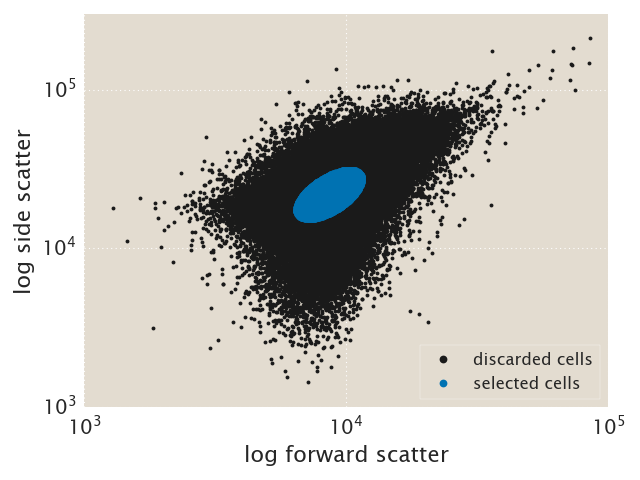

In [56]:
plt.figure()
plt.plot(discarded_cells['FSC-A'], discarded_cells['SSC-A'], 'k.',
                   rasterized=True, label='discarded cells')
plt.plot(selected_cells['FSC-A'], selected_cells['SSC-A'], 'b.',
               rasterized=True, label='selected cells')

# Fix formatting and restrict bounds.
plt.legend(loc='lower right', fontsize=15, markerscale=2)
plt.xlabel('log forward scatter', fontsize=20)
plt.ylabel('log side scatter', fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=18)
# Restrict bounds for aesthetic reasons.
plt.xlim([1E3, 1E5])
plt.ylim([1E3, 3E5])

# Save the figure.
plt.tight_layout()
plt.savefig('/Users/gchure/Dropbox/mwc_induction/figures/supplementary_figures/flow_cloud.pdf',
           bbox_inches='tight')

### Examining fluorescence distributions. 

We would like to compare the fluorescence distributions between microscopy and flow cytometry. We can begin by loading the important CSV files for the microscopy example.

In [59]:
# Load the preprocessed microscopy files.
mic_cells = pd.read_csv('../../data/RBS1027_O2_microscopy_cell_intensities.csv')

We will show the fluorescence intensities for RBS1027 O2 at 250µM IPTG.

<IPython.core.display.Javascript object>


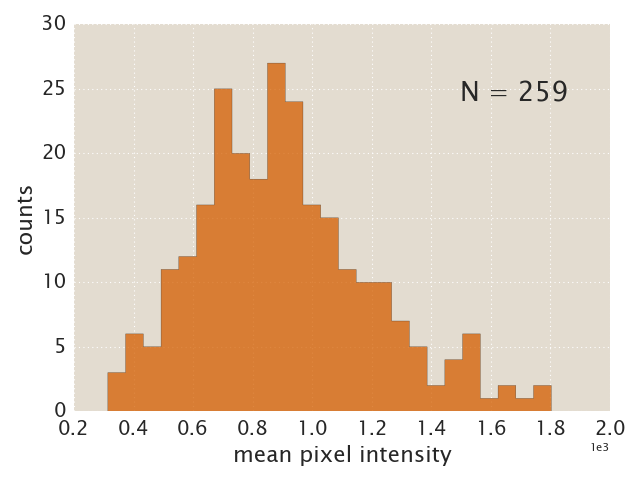

In [117]:
# Select only the desired cells. 
mic_selected = mic_cells[(mic_cells['date'] == 20161019) &
                      (mic_cells['rbs'] == 'RBS1027') &
                      (mic_cells['IPTG_uM'] == 250)].mean_intensity

# Generate the plot. 
plt.figure()
plt.hist(mic_selected, bins=25, color='r', alpha=0.75, histtype='stepfilled')
plt.xlabel('mean pixel intensity', fontsize=20)
plt.ylabel('counts', fontsize=20)
ax = plt.gca()
plt.text(0.72, 0.8, 'N = {0}'.format(len(mic_selected)), transform=ax.transAxes,
        fontsize=24)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,3))
plt.tick_params(labelsize=18)

# Save the figure.
plt.tight_layout()
plt.savefig('/Users/gchure/Dropbox/mwc_induction/figures/supplementary_figures/microscopy_distribution.pdf',
            bbox_inches='tight')

Now we can do the same for the flow cytometry data.

<IPython.core.display.Javascript object>


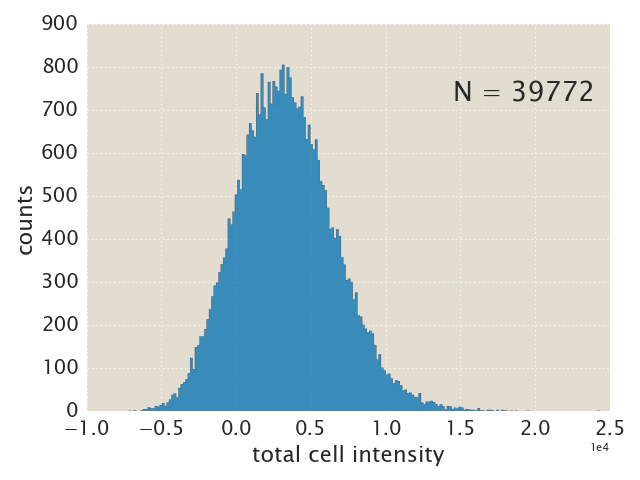

In [118]:
# Generate the plot
plt.figure()
plt.hist(selected_cells['FITC-A'], bins=200, color='b', alpha=0.75,
        histtype='stepfilled')

# Apply formatting
plt.xlabel('total cell intensity', fontsize=20)
plt.ylabel('counts', fontsize=20)
ax = plt.gca()
plt.text(0.7, 0.8, 'N = {0}'.format(len(selected_cells)), transform=ax.transAxes,
        fontsize=24)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,3))
plt.tick_params(labelsize=18)

# Save the figure.
plt.tight_layout()
plt.savefig('/Users/gchure/Dropbox/mwc_induction/figures/supplementary_figures/flow_distribution.pdf',
           bbox_inches='tight')

###  Plotting fold-change with prediction.

To  emphasize how similar these results are, we will plot the fold-change from three independent experiments using both flow cytometry and microscopy keeping the same colorscheme as shown above. 

In [145]:
# Load the csv files.
mic_fc = pd.read_csv('../../data/RBS1027_O2_microscopy_foldchange.csv')
flow_glob = glob.glob('../../data/201608*O2*.csv')
with open('../../data/datasets_ignore.csv') as f:
    ignored_sets = f.readlines()
    ignored_sets = ['../../data/' + z.rstrip() for z in ignored_sets]
    
flow_fc = []
for entry in flow_glob:
    if entry not in ignored_sets:
        samp = pd.read_csv(entry, comment='#') 
        if 'r2' not in entry:
            flow_fc.append(samp)       
flow_fc = pd.concat(flow_fc, axis=0)
flow_fc = flow_fc[flow_fc['rbs']=='RBS1027']

With the data sets in hand, we can plot the points and prediction on the same axes.

<IPython.core.display.Javascript object>


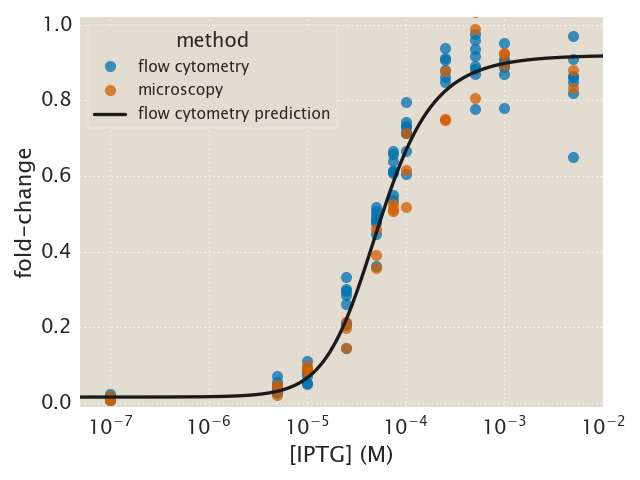

In [166]:
#plot the prediction
# Define the necessary parameters.
epa = -np.log(141E-6)
epi = -np.log(0.56E-6)
epr = -13.9  # In units of kBT
iptg = np.logspace(-8, -2, 1000)
R = np.array([130])  # Number of lac tetramers per cell.

# Generate the theoretical fold change.
fc = mwc.fold_change_log(iptg, epa, epi, 4.5, R, epr)

# Generate the plot.
plt.figure()
plt.plot(flow_fc['IPTG_uM']/1E6, flow_fc['fold_change_A'], 'bo', markersize=10,
        alpha=0.75)
plt.plot(mic_fc['IPTG_uM'], mic_fc['fold_change'], 'ro', markersize=10,
        alpha=0.75)
plt.plot(iptg, fc,'k-', linewidth=3)
plt.xscale('log')
legend = plt.legend(['flow cytometry', 'microscopy', 'flow cytometry prediction'], loc='upper left',
          title='method', fontsize=14)
plt.setp(legend.get_title(),fontsize=18)
plt.xlabel('[IPTG] (M)', fontsize=20)
plt.ylabel('fold-change', fontsize=20)
plt.tick_params(labelsize=18)
plt.ylim([-0.01, 1.02])
plt.xlim([5E-8,1E-2])
plt.tight_layout()
plt.savefig('/Users/gchure/Dropbox/mwc_induction/figures/supplementary_figures/microscopy_flow_prediction_plot.pdf',
           bbox_inches='tight')